In [1]:
import gym
import torch.nn as nn
import torch 
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
env = gym.make('CartPole-v1')
state_space = env.observation_space.shape
action_space = env.action_space.n
state_space, action_space

((4,), 2)

In [3]:
class DQN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(state_space[0], 128)
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, action_space)

    def forward(self, x):
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        return self.layer_3(x)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
q_network = DQN().to(device)
target_network = DQN().to(device)
target_network.load_state_dict(q_network.state_dict())

<All keys matched successfully>

In [6]:
class ReplayBuffer:
    def __init__(self, max_size, batch_size, state_space):
        self.max_size = max_size
        self.batch_size = batch_size
        self.counter = 0
        self.states = np.zeros((max_size, *state_space))
        self.actions = np.zeros(max_size, dtype=np.int32)
        self.next_states = np.zeros((max_size, *state_space))
        self.rewards = np.zeros(max_size)
        self.dones = np.zeros(max_size)

    def store(self, state, action, reward, next_state, done):
        idx = self.counter % self.max_size
        self.states[idx] = state
        self.actions[idx] = action
        self.rewards[idx] = reward
        self.next_states[idx] = next_state
        self.dones[idx] = done
        self.counter += 1

    def sample(self):
        max_index = min(self.max_size, self.counter)
        if max_index < self.batch_size:
            raise ValueError('Insufficient samples in buffer')
        indices = np.random.randint(0, max_index, size=self.batch_size)
        return (
            torch.FloatTensor(self.states[indices]).to(device),
            torch.LongTensor(self.actions[indices]).to(device),
            torch.FloatTensor(self.rewards[indices]).to(device),
            torch.FloatTensor(self.next_states[indices]).to(device),
            torch.FloatTensor(self.dones[indices]).to(device)
        )


In [7]:
optimizer = optim.RMSprop(q_network.parameters(), lr=0.0001)
replay_buffer = ReplayBuffer(10000, 128, state_space)
n_games = 600
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
tau = 0.005
scores = []


In [8]:

for episode in range(n_games):
    state = env.reset()  # Updated reset call for newer gym versions
    score = 0
    done = False

    while not (done):
        # Action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = q_network(state_tensor)
                action = torch.argmax(q_values).item()

        # Environment step
        next_state, reward, done, _ = env.step(action)
        replay_buffer.store(state, action, reward, next_state, done)
        state = next_state
        score += reward

        # Training step
        if replay_buffer.counter > replay_buffer.batch_size:
            states, actions, rewards, next_states, dones = replay_buffer.sample()
            
            with torch.no_grad():
                next_q_values = target_network(next_states)
                max_next_q_values = next_q_values.max(1)[0]
                targets = rewards + gamma * max_next_q_values * (1 - dones)
            
            current_q_values = q_network(states)
            current_q_values = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
            
            loss = F.mse_loss(current_q_values, targets)
            
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(q_network.parameters(), 100)
            optimizer.step()

            # Update target network
            for target_param, param in zip(target_network.parameters(), q_network.parameters()):
                target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    # Update epsilon and record score
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    scores.append(score)
    print(f'Episode {episode + 1}: Score = {score}, Epsilon = {epsilon:.3f}')

Episode 1: Score = 15.0, Epsilon = 0.995
Episode 2: Score = 21.0, Epsilon = 0.990
Episode 3: Score = 15.0, Epsilon = 0.985
Episode 4: Score = 19.0, Epsilon = 0.980
Episode 5: Score = 12.0, Epsilon = 0.975
Episode 6: Score = 25.0, Epsilon = 0.970
Episode 7: Score = 21.0, Epsilon = 0.966
Episode 8: Score = 9.0, Epsilon = 0.961
Episode 9: Score = 18.0, Epsilon = 0.956
Episode 10: Score = 19.0, Epsilon = 0.951
Episode 11: Score = 15.0, Epsilon = 0.946
Episode 12: Score = 16.0, Epsilon = 0.942
Episode 13: Score = 13.0, Epsilon = 0.937
Episode 14: Score = 8.0, Epsilon = 0.932
Episode 15: Score = 11.0, Epsilon = 0.928
Episode 16: Score = 23.0, Epsilon = 0.923
Episode 17: Score = 25.0, Epsilon = 0.918
Episode 18: Score = 12.0, Epsilon = 0.914
Episode 19: Score = 12.0, Epsilon = 0.909
Episode 20: Score = 13.0, Epsilon = 0.905
Episode 21: Score = 14.0, Epsilon = 0.900
Episode 22: Score = 17.0, Epsilon = 0.896
Episode 23: Score = 28.0, Epsilon = 0.891
Episode 24: Score = 14.0, Epsilon = 0.887
Epi

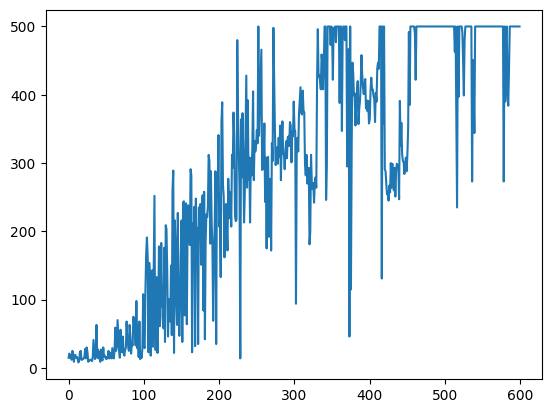

In [10]:
plt.plot(scores)
plt.show()